In [1]:
import pickle
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

import seaborn as sns

from finite_ntk import utils

In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
from matplotlib import rc

rc('text', usetex = True)
rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath'])
#rc('font', **{'family': 'sans-serif','sans-serif':['DejaVu Sans']})

rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

#plt.rcParams["font.family"] = "serif"

import matplotlib.lines as mlines
import matplotlib.colors as colors
from matplotlib import scale as mcscale
from matplotlib import transforms as mtransforms

palette = sns.color_palette('colorblind')
sns.set_palette('colorblind')

In [4]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import argparse
import time
import pickle
import sys
import finite_ntk

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    # exact RBF Gaussian process class
    def __init__(self, train_x, train_y, likelihood, model, use_linearstrategy=False):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = finite_ntk.lazy.NTK(
            model=model, use_linearstrategy=use_linearstrategy
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
torch.random.manual_seed(10)
datapoints = 150

full_x = torch.linspace(-15., 15., steps=1000).view(-1,1)
train_x = torch.cat((0.8*torch.randn(datapoints, 1)-5., 0.8*torch.randn(datapoints, 1)+5.), dim=0)
print(train_x.shape)

torch.Size([300, 1])


In [7]:

def gen_model(nhid=50):
    return torch.nn.Sequential(
        torch.nn.Linear(1, nhid),
        torch.nn.ReLU(),
        #torch.nn.Linear(40, 40),
        # torch.nn.ReLU(), torch.nn.Linear(40, 40),
        #torch.nn.ReLU(),
        torch.nn.Linear(nhid, 1),
    )

In [8]:
# draw sample function from true model
with torch.no_grad():
    #true_model = gen_model()
    #train_y = true_model(train_x) + 0.4 * torch.rand_like(train_x)
    train_y = 0.1 * train_x**2 + train_x.abs() + 0.9 * torch.randn_like(train_x)

In [9]:
def compute_storage_dict(nhid=50, train_model=False):

    # generate model
    model = gen_model(nhid)

    # train model
    if train_model:
        utils.train_fullds(model, train_x, train_y, iterations=250, lr=1e-4, momentum=0.9)

    # construct likelihood and gp model
    gplh = gpytorch.likelihoods.GaussianLikelihood()
    gpmodel = ExactGPModel(
        train_x, train_y.squeeze(), gplh, model, use_linearstrategy=True
    )

    # set noise to be smaller
    print("residual error: ", torch.mean((model(train_x) - train_y) ** 2))
    with torch.no_grad():
        gplh.noise = torch.max(
            1e-3 * torch.ones(1), torch.mean((model(train_x) - train_y) ** 2)
        )
        # gplh.noise = 1e-2 * torch.ones(1)
        print("noise is: ", gplh.noise)

    gpmodel.train()
    logprob = gplh(gpmodel(train_x))

    with gpytorch.settings.fast_pred_var(), gpytorch.settings.cg_tolerance(1e-1):
        start = time.time()
        gpmodel.eval()
        predictive_dist = gpmodel(full_x)

        print("into the predictive mean")
        pmean = predictive_dist.mean.data
        print("now confidence region")
        lower, upper = predictive_dist.confidence_region()
        lower = lower.detach()
        upper = upper.detach()

        end = time.time() - start

    #fig, ax = plt.subplots()

    plotting_data_dict = {
        "train": {
            "x": train_x.data.cpu().numpy(),
            "y": train_y.data.cpu().numpy(),
            "pred": model(full_x).data.cpu().numpy(),
            "full_x": full_x.cpu().numpy(),
            "full_pred": pmean.cpu().numpy(),
            "lower": lower.data.cpu().numpy(),
            "upper": upper.data.cpu().numpy(),
        }
    }
    
    return plotting_data_dict

In [10]:
with gpytorch.settings.max_cholesky_size(0):
    output_list = [5, 50, 500, 5000]
    untrained_hidden_outputs = [compute_storage_dict(oo) for oo in output_list]



residual error:  tensor(54.9822, grad_fn=<MeanBackward0>)
noise is:  tensor([54.9822])
into the predictive mean
now confidence region
residual error:  tensor(49.6184, grad_fn=<MeanBackward0>)
noise is:  tensor([49.6184])
into the predictive mean
now confidence region
residual error:  tensor(63.0736, grad_fn=<MeanBackward0>)
noise is:  tensor([63.0736])
into the predictive mean
now confidence region
residual error:  tensor(84.4176, grad_fn=<MeanBackward0>)
noise is:  tensor([84.4176])
torch.Size([15001])
into the predictive mean
now confidence region


In [11]:
with gpytorch.settings.max_cholesky_size(0):
    trained_hidden_outputs = [compute_storage_dict(oo, train_model=True) for oo in output_list]

tensor(48.1671, grad_fn=<MseLossBackward>)
tensor(0.9723, grad_fn=<MseLossBackward>)
tensor(0.7783, grad_fn=<MseLossBackward>)
tensor(0.8677, grad_fn=<MseLossBackward>)
tensor(1.0788, grad_fn=<MseLossBackward>)
tensor(0.8042, grad_fn=<MseLossBackward>)
tensor(0.7014, grad_fn=<MseLossBackward>)
tensor(1.0320, grad_fn=<MseLossBackward>)
tensor(1.1382, grad_fn=<MseLossBackward>)
tensor(0.8943, grad_fn=<MseLossBackward>)
residual error:  tensor(0.8757, grad_fn=<MeanBackward0>)
noise is:  tensor([0.8757])
into the predictive mean
now confidence region
tensor(60.8574, grad_fn=<MseLossBackward>)
tensor(0.7999, grad_fn=<MseLossBackward>)
tensor(1.0611, grad_fn=<MseLossBackward>)
tensor(0.9011, grad_fn=<MseLossBackward>)
tensor(0.8733, grad_fn=<MseLossBackward>)
tensor(0.7274, grad_fn=<MseLossBackward>)
tensor(0.6852, grad_fn=<MseLossBackward>)
tensor(0.8922, grad_fn=<MseLossBackward>)
tensor(1.0009, grad_fn=<MseLossBackward>)
tensor(0.9285, grad_fn=<MseLossBackward>)
residual error:  tensor(0.

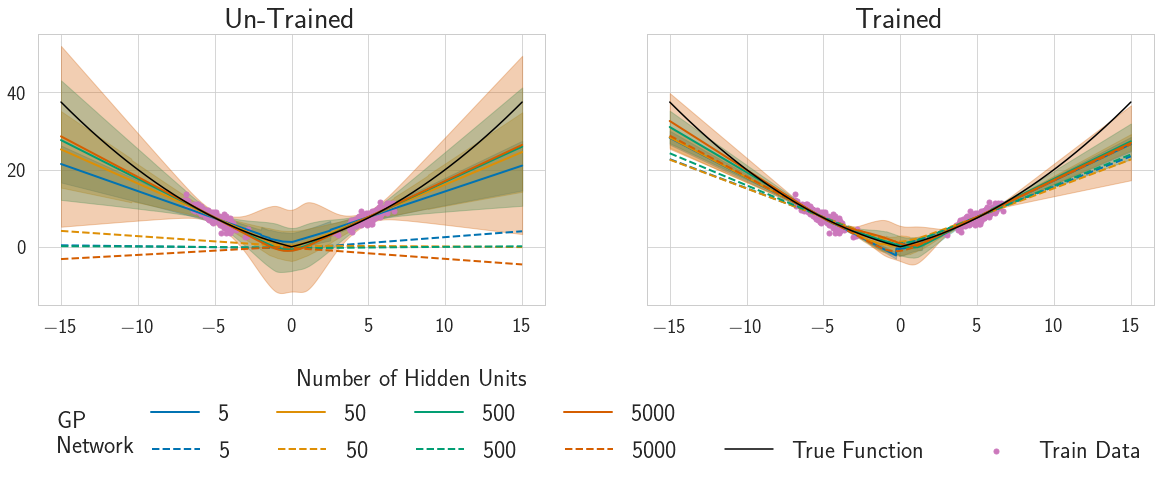

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20,5), sharey=True)

#ax[0].set_ylim((-25,25))


for ntk_dict, nhidden, col in zip(untrained_hidden_outputs, output_list, sns.color_palette()):
    ax[0].plot(ntk_dict['train']['full_x'], ntk_dict['train']['full_pred'], color = col, 
                linewidth = 2)
    ax[0].plot(ntk_dict['train']['full_x'], ntk_dict['train']['pred'], color = col, 
                linewidth = 2, linestyle='--', label=str(nhidden))
    ax[0].fill_between(ntk_dict['train']['full_x'][...,0], 
               ntk_dict['train']['lower'], ntk_dict['train']['upper'],
                        color = col, alpha = 0.3)

full_y = 0.1 * full_x**2 + full_x.abs() 
ax[0].plot(full_x, full_y, color='black', label = 'True Function')

ax[0].scatter(ntk_dict['train']['x'],ntk_dict['train']['y'], label = 'Train Data', color=sns.color_palette()[4],
              s = 25)
#ax[0].legend(title='Number of Hidden Units')
ax[0].set_title('Un-Trained', fontsize = 30)
l = ax[0].legend(title='GP \n Network', fontsize=24, loc='upper center',
            bbox_to_anchor=(1.2, -0.2),fancybox=False, shadow=False, ncol=6,
                title_fontsize=24)
l.get_title().set_position((-550, -30))
#ax[1].set_ylim((-8,8))

for ntk_dict, nhidden, col in zip(trained_hidden_outputs, output_list, sns.color_palette()):
    ax[1].plot(ntk_dict['train']['full_x'], ntk_dict['train']['full_pred'], color = col, 
                linewidth = 2, label = str(nhidden))
    ax[1].plot(ntk_dict['train']['full_x'], ntk_dict['train']['pred'], color = col, 
                linewidth = 2, linestyle='--')
    ax[1].fill_between(ntk_dict['train']['full_x'][...,0], 
               ntk_dict['train']['lower'], ntk_dict['train']['upper'],
                        color = col, alpha = 0.3)
full_y = 0.1 * full_x**2 + full_x.abs() 
ax[1].plot(full_x, full_y, color='black')

ax[1].scatter(ntk_dict['train']['x'],ntk_dict['train']['y'], color=sns.color_palette()[4],
              s = 25)
ax[1].legend(title='Number of Hidden Units', fontsize=24, loc='upper center',
            bbox_to_anchor=(-0.46, -0.15),fancybox=False, shadow=False, ncol=6., 
            title_fontsize=24)
ax[1].set_title('Trained', fontsize = 30)

plt.savefig('../../../Papers/ntk_paper/icml2020/figs/relu_plot.pdf', bbox_inches='tight')